In [1]:
import matplotlib
import os
os.chdir('../sim')

In [2]:
# !nrnivmodl -coreneuron mod/
# !nrnivmodl mod/

In [3]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np
import pandas as pd

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.simType='run_subNets'
cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 1.0*1e0 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'cell': 4321, 'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -71}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = True

# S1 pop
cfg.poptypeNumber = 55 # m-types
cfg.celltypeNumber = 207 # me-types

cfg.rootFolder = os.getcwd()

In [4]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('cells/S1-cells-distributions-Human.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname[0:-3]

    if mtype not in popParam:
        popParam.append(mtype)
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])

    # print(cellname, mtype, etype, n, m)
    
cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam


In [5]:
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

cfg.Ecells = [] 
cfg.h01_mtype = {}

for metype in cfg.S1cells: # metype    

    mtype = cfg.popLabel[metype]

    if mtype[1] == '2':
        layer = 'L23'      
    else:
        layer = mtype[0:2]         

    if mtype in Epops:  
        cfg.h01_mtype[layer+'E'] = 0
        cfg.Ecells.append(metype)      
    else:
        cfg.h01_mtype[layer+'I'] = 0
        
for metype in cfg.S1cells: # metype    

    mtype = cfg.popLabel[metype]

    if mtype[1] == '2':
        layer = 'L23'      
    else:
        layer = mtype[0:2]         

    if mtype in Epops:  
        cfg.h01_mtype[layer+'E'] = cfg.h01_mtype[layer+'E'] + cfg.cellNumber[metype]
    else:
        cfg.h01_mtype[layer+'I'] = cfg.h01_mtype[layer+'I'] + cfg.cellNumber[metype]
        

In [6]:
nodes_new = pd.read_csv('../data/cell_positions_h01_rotated.csv')

In [33]:
cfg.cylinderRadius_h01 = 300.0 # 

In [34]:
h01type, h01Number = np.unique(nodes_new[nodes_new['distance2Dcenter'] < cfg.cylinderRadius_h01]['mtype'].values, return_counts=True)
h01type, h01Number

(array(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'],
       dtype=object),
 array([ 241, 1608,  890,  945,  236,  694,  210,  604,   99]))

In [9]:
cfg.h01_ratio_number = {}
cfg.List_h01 = {}
print('layer','\t','h01','\t','S1','\t', "perc\n")
for h01N, h01t in enumerate(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']):
    cfg.h01_ratio_number[h01t] = h01Number[h01N]/cfg.h01_mtype[h01t]
    print(h01t,'\t',h01Number[h01N],'\t',cfg.h01_mtype[h01t],'\t',"%.2f" % (100.0*cfg.h01_ratio_number[h01t]))
    cfg.List_h01[h01t] = []

for mtype in cfg.S1pops:

    if mtype[1] == '2':
        layer = 'L23'      
    else:
        layer = mtype[0:2]         

    if mtype in Epops:    
        h01t = layer+'E'
    else:
        h01t = layer+'I'    

    cfg.List_h01[h01t].append(mtype)

# cfg.List_h01

layer 	 h01 	 S1 	 perc

L1I 	 554 	 338 	 163.91
L23E 	 4908 	 5877 	 83.51
L23I 	 2604 	 1647 	 158.11
L4E 	 2744 	 4178 	 65.68
L4I 	 692 	 478 	 144.77
L5E 	 1774 	 5050 	 35.13
L5I 	 498 	 1064 	 46.80
L6E 	 1429 	 11462 	 12.47
L6I 	 231 	 1252 	 18.45


In [10]:
cfg.popNumber_new = {}
number=0
listnew = []

for h01N, h01t in enumerate(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']):
# for h01t in cfg.List_h01.keys():
    number=0
    print()

    for mtype in cfg.List_h01[h01t]:

        if mtype[1] == '2':
            layer = 'L23'      
        else:
            layer = mtype[0:2]         


        cfg.popNumber_new[mtype] = int(0.5 + cfg.popNumber[mtype] * cfg.h01_ratio_number[h01t]) 
        
        number+=cfg.popNumber_new[mtype]

        print(mtype, cfg.popNumber[mtype], cfg.popNumber_new[mtype], h01Number[h01N], number)
        
    cfg.popNumber_new[mtype] = cfg.popNumber_new[mtype] + h01Number[h01N] - number
    number+= h01Number[h01N] - number

    print(" ",mtype, cfg.popNumber[mtype], cfg.popNumber_new[mtype], h01Number[h01N], number)
        



L1_DAC 58 95 554 95
L1_DLAC 24 39 554 134
L1_HAC 91 149 554 283
L1_NGC-DA 72 118 554 401
L1_NGC-SA 52 85 554 486
L1_SLAC 41 67 554 553
  L1_SLAC 41 68 554 554

L23_PC 5877 4908 4908 4908
  L23_PC 5877 4908 4908 4908

L23_BP 28 44 2604 44
L23_BTC 104 164 2604 208
L23_DBC 175 277 2604 485
L23_LBC 456 721 2604 1206
L23_MC 333 526 2604 1732
L23_NBC 268 424 2604 2156
L23_SBC 166 262 2604 2418
L23_ChC 61 96 2604 2514
L23_NGC 56 89 2604 2603
  L23_NGC 56 90 2604 2604

L4_PC 2674 1756 2744 1756
L4_SP 1098 721 2744 2477
L4_SS 406 267 2744 2744
  L4_SS 406 267 2744 2744

L4_BP 8 12 692 12
L4_BTC 20 29 692 41
L4_DBC 40 58 692 99
L4_LBC 122 177 692 276
L4_ChC 8 12 692 288
L4_MC 118 171 692 459
L4_NBC 96 139 692 598
L4_NGC 6 9 692 607
L4_SBC 60 87 692 694
  L4_SBC 60 85 692 692

L5_STPC 302 106 1774 106
L5_TTPC1 2403 844 1774 950
L5_TTPC2 2003 704 1774 1654
L5_UTPC 342 120 1774 1774
  L5_UTPC 342 120 1774 1774

L5_BP 34 16 498 16
L5_BTC 76 36 498 52
L5_DBC 96 45 498 97
L5_NBC 201 94 498 191
L5_NGC

In [11]:
cfg.cellNumber_new = {}

for mtype in cfg.S1pops:
    print()
    number=0
    for cellEl in range(min(np.size(cfg.popLabelEl[mtype]),cfg.popNumber_new[mtype])):

        metype = cfg.popLabelEl[mtype][cellEl]

        if cfg.popNumber_new[mtype] <= np.size(cfg.popLabelEl[mtype]):
            cfg.cellNumber_new[metype] = int(1.0)
        else:
            cfg.cellNumber_new[metype] = int(0.5 + cfg.cellNumber[metype]*cfg.popNumber_new[mtype]/cfg.popNumber[mtype])

        number+=cfg.cellNumber_new[metype]

        print(int(number), metype, cfg.cellNumber[metype], mtype, cfg.popNumber_new[mtype],cfg.cellNumber_new[metype])

    cfg.cellNumber_new[metype] = cfg.cellNumber_new[metype] + cfg.popNumber_new[mtype] - number
    print(" ", int(number), metype, cfg.cellNumber[metype], mtype, cfg.popNumber_new[mtype],cfg.cellNumber_new[metype])


    if cfg.cellNumber_new[metype] == 0:

        if  cfg.cellNumber_new['L6_DBC_cAC'] == 2 and cfg.cellNumber_new['L6_DBC_cNA'] == 0:
            print(" ########### \n fixing cellNumber_new = 0 for L6_DBC_cNA")
            cfg.cellNumber_new['L6_DBC_cAC'] = 1
            cfg.cellNumber_new['L6_DBC_cNA'] = 1
            print(" ", int(number), metype, cfg.cellNumber[metype], mtype, cfg.popNumber_new[mtype],cfg.cellNumber_new[metype])

        if cfg.cellNumber_new[metype] == 0:
            print("fix this like above")
            break




95 L1_DAC_cNA 58 L1_DAC 95 95
  95 L1_DAC_cNA 58 L1_DAC 95 95

39 L1_DLAC_cNA 24 L1_DLAC 39 39
  39 L1_DLAC_cNA 24 L1_DLAC 39 39

34 L1_HAC_bNA 21 L1_HAC 149 34
149 L1_HAC_cNA 70 L1_HAC 149 115
  149 L1_HAC_cNA 70 L1_HAC 149 115

15 L1_NGC-DA_bNA 9 L1_NGC-DA 118 15
30 L1_NGC-DA_cAC 9 L1_NGC-DA 118 15
119 L1_NGC-DA_cNA 54 L1_NGC-DA 118 89
  119 L1_NGC-DA_cNA 54 L1_NGC-DA 118 88

85 L1_NGC-SA_cNA 52 L1_NGC-SA 85 85
  85 L1_NGC-SA_cNA 52 L1_NGC-SA 85 85

23 L1_SLAC_bNA 14 L1_SLAC 68 23
36 L1_SLAC_cAC 8 L1_SLAC 68 13
68 L1_SLAC_cNA 19 L1_SLAC 68 32
  68 L1_SLAC_cNA 19 L1_SLAC 68 32

6 L23_BP_bAC 4 L23_BP 44 6
20 L23_BP_bNA 9 L23_BP 44 14
34 L23_BP_cAC 9 L23_BP 44 14
43 L23_BP_cNA 6 L23_BP 44 9
  43 L23_BP_cNA 6 L23_BP 44 10

25 L23_BTC_bAC 16 L23_BTC 164 25
64 L23_BTC_bNA 25 L23_BTC 164 39
133 L23_BTC_cAC 44 L23_BTC 164 69
163 L23_BTC_cNA 19 L23_BTC 164 30
  163 L23_BTC_cNA 19 L23_BTC 164 31

24 L23_DBC_bAC 15 L23_DBC 277 24
160 L23_DBC_bNA 86 L23_DBC 277 136
277 L23_DBC_cAC 74 L23_DBC 27

In [12]:
number=0
for mtype in cfg.S1pops:
    for cellEl in range(np.size(cfg.popLabelEl[mtype])):

        metype = cfg.popLabelEl[mtype][cellEl]

        try:
            number+=cfg.cellNumber_new[metype]
        except:
            print(metype, "not inclued for this size")

print(number)


cfg.popLabelEl = {} 
for metype in cfg.cellNumber_new.keys():

    mtype = cfg.popLabel[metype] 

    if mtype not in cfg.popLabelEl.keys():
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    

number=0
for mtype in cfg.S1pops:
    for cellEl in range(np.size(cfg.popLabelEl[mtype])):

        metype = cfg.popLabelEl[mtype][cellEl]

        try:
            number+=cfg.cellNumber_new[metype]
        except:
            print(metype, "not inclued for this size")

print(number)


15434
15434


In [13]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = True    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = False 

In [14]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		cellname, mtype, etype, n, m = line.split()
		metype = mtype + '_' + etype[0:3]
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [15]:
len(cfg.cellNumber_new.keys()), len(cfg.popNumber_new.keys())

(134, 55)

In [16]:
cfg.S1pops = list(cfg.popNumber_new.keys())
cfg.S1cells = list(cfg.cellNumber_new.keys())

cfg.popParamLabels = list(cfg.popNumber_new.keys())
cfg.cellParamLabels = list(cfg.cellNumber_new.keys())

## Run only selected populations (me-types)

In [17]:
# subPopLabels = ['L1_DAC','L1_DLAC',#'L1_HAC','L1_NGC_DA','L1_NGC_SA','L1_SLAC',
#  'L23_PC','L23_MC','L23_SBC', #'L23_BP','L23_BTC','L23_ChC','L23_DBC','L23_LBC','L23_NBC','L23_NGC',
#  'L4_PC','L4_SBC','L4_MC', # 'L4_BP','L4_BTC','L4_ChC','L4_DBC','L4_LBC','L4_NBC','L4_NGC','L4_SP','L4_SS',
#  'L5_TTPC2','L5_SBC','L5_MC', #'L5_BP','L5_BTC','L5_ChC','L5_DBC','L5_LBC','L5_NBC','L5_NGC','L5_STPC','L5_TTPC1','L5_UTPC',
#  'L6_TPC_L4','L6_SBC','L6_MC'] #,'L6_BPC','L6_BP','L6_BTC','L6_ChC','L6_DBC','L6_IPC','L6_LBC','L6_NBC','L6_NGC','L6_TPC_L1','L6_UTPC']

# INH
# PV, SST, VIP

# subPopLabels = ['L1_HAC','L23_MC','L4_SP', 'L5_TTPC2','L6_LBC']


In [18]:
# subPopLabels = cfg.S1pops#[36:38] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14
#------------------------------------------------------------------------------  
# subPopLabels = cfg.S1pops
# cfg.S1pops = subPopLabels
# cfg.S1cells = []
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:        
#         cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

# cfg.popParamLabels = cfg.S1pops
# cfg.cellParamLabels = cfg.S1cells

# cfg.cellNumber[metype]
# cfg.popNumber[cfg.popLabel[metype]]
#------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   
    
#------------------------------------------------------------------------------  
## Change popNumber
#------------------------------------------------------------------------------  
# cfg.cellNumber[metype] = 25
# cfg.popNumber[cfg.popLabel[metype]] = 25
# #------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   

In [19]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 1
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)
                
        
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False
cfg.recordTime = False
cfg.recordStep = 0.1    

In [20]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNet_1'
cfg.saveFolder = '../runSubNets/'+cfg.simLabel
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False	           	## Save json file
cfg.saveDataInclude = ['simData'] ## , 'netParams', 'simConfig', ,'simData'
cfg.backupCfgFile = None
cfg.gatherOnlySimData = False
cfg.saveCellSecs = False
cfg.saveCellConns = True

In [21]:
"""
netParams.py
"""
# Rat data
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	

# L23 Human net
# #              L2/3   L4     L5
# PYRmaxApics = [550   ,1550   ,1900]
# uppers =      [-250  ,-1200 ,-1600]
# lowers =      [-1200 ,-1580 ,-2300]


# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

soma_area_scaling_factor = 2.453
axon_diameter_scaling_factor = 2.453
main_axon_diameter_scaling_factor = 1
apic_diameter_scaling_factor = 1.876
dend_diameter_scaling_factor = 1.946
dend_length_scaling_factor = 1.17

cfg.sizeY = 2556.35
cfg.sizeX = 600.0
cfg.sizeZ = 600.0

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY# y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume


layer = {'1':[0.0, 0.17431214670060], '2': [0.17431214670060,0.3037022055398974], '3': [0.3037022055398974,0.48032628269160704], 
        '23': [0.17431214670060,0.48032628269160704], '4':[0.48032628269160704,0.6014535025371577], '5': [0.6014535025371577,0.7881702928423451], 
        '6': [0.7881702928423451,1.0], 'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


nodesinfo = nodes_new[nodes_new['distance2Dcenter'] < cfg.cylinderRadius_h01]

print(np.unique(nodesinfo['layer'].values, return_counts=True) , np.unique(nodesinfo['mtype'].values, return_counts=True) , [(3200.929881191896 - max(nodesinfo[nodesinfo['layer']==ii]['y_new'].values))/(3200.929881191896-644.581391561247) for ii in [1,2,3,4,5,6]])

(array([1, 2, 3, 4, 5, 6, 7]), array([ 554, 4743, 2769, 3436, 2272, 1048,  612])) (array(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'],
      dtype=object), array([ 554, 4908, 2604, 2744,  692, 1774,  498, 1429,  231])) [-0.015723726062813075, 0.17431214670060036, 0.3037022055398974, 0.48032628269160704, 0.6014535025371577, 0.7881702928423451]


In [22]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------

cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

In [23]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [24]:
number=0
cfg.pyr_positions = {}

for h01N, h01t in enumerate(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']):

    listPositions = list(nodesinfo[nodesinfo['mtype']==h01t].index)
    np.random.seed(0)
    shuffled_array = np.random.permutation(listPositions)
    
    gid1 = 0

    for mtype in cfg.List_h01[h01t]:

        if mtype[1] == '2':
            layer = 'L23'      
        else:
            layer = mtype[0:2]         

        for cellEl in range(np.size(cfg.popLabelEl[mtype])):

            metype = cfg.popLabelEl[mtype][cellEl]

            try:
                gid2 = gid1 + cfg.cellNumber_new[metype]
                cfg.pyr_positions[metype] = [[float(nodesinfo['x_new'][gid]) , float(nodesinfo['y_new'][gid]) , float(nodesinfo['z_new'][gid])] for gid in shuffled_array[gid1:gid2]]
                gid1 = gid1 + cfg.cellNumber_new[metype]
            except:            
                cfg.pyr_positions[metype] = []

            number+=len(cfg.pyr_positions[metype])
            # print(metype,len(cfg.pyr_positions[metype]))
print(number)


15434


In [25]:
# len(pyr_positions), len(cfg.S1cells)
# # cellsList not working with 'diversity': True yet!!!
# for cellName in cfg.S1cells:  
#     cellsList = [{'x': x, 'y': y, 'z': z} for x,y,z in pyr_positions[cellName]]  
#     netParams.popParams[cellName] = {'cellType': cellName, 'cellsList': cellsList, 'cellModel': 'HH_full', 'diversity': True}

In [26]:
# ------------------------------------------------------------------------------
# Population parameters
# ------------------------------------------------------------------------------
# S1
cfg.scaleDensity = 1.0

layer = {'1':[0.0, 0.17431214670060], '2': [0.17431214670060,0.3037022055398974], '3': [0.3037022055398974,0.48032628269160704], 
        '23': [0.17431214670060,0.48032628269160704], '4':[0.48032628269160704,0.6014535025371577], '5': [0.6014535025371577,0.7881702928423451], 
        '6': [0.7881702928423451,1.0], 'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


for cellName in cfg.S1cells:
	layernumber = cellName[1:2]
	if layernumber == '2':
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName])), 'diversity': True}
	else:
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName])), 'diversity': True}

In [27]:
netParams.popParams[cellName]

{'cellType': 'L6_NBC_cNA',
 'cellModel': 'HH_full',
 'ynormRange': [0.7881702928423451, 1.0],
 'numCells': 15,
 'diversity': True}

In [28]:
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
## S1 cell property rules

smaller_number_of_axon_sections = {'L1_DAC_bNA': 2, 'L1_DAC_cNA': 1, 'L1_DLAC_cNA': 4, 'L1_HAC_bNA': 3, 'L1_HAC_cIR': 5, 'L1_HAC_cNA': 4, 'L1_NGC-DA_bNA': 3, 
                                   'L1_NGC-DA_cAC': 3, 'L1_NGC-DA_cNA': 5, 'L1_NGC-DA_cST': 3, 'L1_NGC-SA_cNA': 4, 'L1_SLAC_bNA': 4, 'L1_SLAC_cAC': 1, 'L1_SLAC_cNA': 1, 
                                   'L23_BP_bAC': 1, 'L23_BP_bIR': 1, 'L23_BP_bNA': 2, 'L23_BP_cAC': 3, 'L23_BP_cNA': 2, 'L23_BP_dST': 1, 'L23_BTC_bAC': 5, 'L23_BTC_bIR': 5, 
                                   'L23_BTC_bNA': 5, 'L23_BTC_cAC': 5, 'L23_BTC_cNA': 5, 'L23_ChC_cAC': 4, 'L23_ChC_cNA': 3, 'L23_ChC_dNA': 3, 'L23_DBC_bAC': 1, 
                                   'L23_DBC_bIR': 1, 'L23_DBC_bNA': 5, 'L23_DBC_cAC': 5, 'L23_LBC_bAC': 3, 'L23_LBC_bNA': 3, 'L23_LBC_cAC': 3, 'L23_LBC_cNA': 4, 
                                   'L23_LBC_cST': 3, 'L23_LBC_dNA': 3, 'L23_MC_bAC': 4, 'L23_MC_bNA': 4, 'L23_MC_cAC': 1, 'L23_MC_cNA': 2, 'L23_MC_dNA': 2, 'L23_NBC_bAC': 5, 
                                   'L23_NBC_bNA': 1, 'L23_NBC_cAC': 4, 'L23_NBC_cIR': 5, 'L23_NBC_cNA': 1, 'L23_NBC_dNA': 1, 'L23_NGC_bNA': 2, 'L23_NGC_cAC': 2, 'L23_NGC_cNA': 2, 
                                   'L23_NGC_cST': 2, 'L23_PC_cAD': 5, 'L23_SBC_bNA': 3, 'L23_SBC_cAC': 3, 'L23_SBC_dNA': 3, 'L4_BP_bAC': 1, 'L4_BP_bIR': 1, 'L4_BP_bNA': 1, 
                                   'L4_BP_cAC': 2, 'L4_BP_cNA': 1, 'L4_BP_dST': 1, 'L4_BTC_bAC': 2, 'L4_BTC_bIR': 2, 'L4_BTC_bST': 2, 'L4_BTC_cAC': 4, 'L4_BTC_cNA': 2, 
                                   'L4_BTC_dNA': 2, 'L4_ChC_cAC': 1, 'L4_ChC_cNA': 1, 'L4_ChC_dNA': 1, 'L4_DBC_bAC': 1, 'L4_DBC_bIR': 5, 'L4_DBC_bNA': 1, 'L4_DBC_bST': 1, 
                                   'L4_DBC_cAC': 1, 'L4_DBC_cIR': 1, 'L4_DBC_cNA': 1, 'L4_LBC_cAC': 1, 'L4_LBC_cNA': 2, 'L4_LBC_cST': 1, 'L4_LBC_dNA': 4, 'L4_LBC_dST': 1, 
                                   'L4_MC_bAC': 3, 'L4_MC_bNA': 1, 'L4_MC_cAC': 1, 'L4_MC_cNA': 4, 'L4_MC_dNA': 4, 'L4_NBC_cAC': 1, 'L4_NBC_cIR': 4, 'L4_NBC_cNA': 1, 
                                   'L4_NBC_dNA': 2, 'L4_NGC_bNA': 1, 'L4_NGC_cAC': 1, 'L4_NGC_cNA': 2, 'L4_NGC_cST': 1, 'L4_PC_cAD': 4, 'L4_SBC_bNA': 5, 'L4_SBC_cAC': 2, 
                                   'L4_SBC_dNA': 2, 'L4_SP_cAD': 2, 'L4_SS_cAD': 3, 'L5_BP_bAC': 1, 'L5_BP_bIR': 1, 'L5_BP_bNA': 1, 'L5_BP_cAC': 3, 'L5_BP_cNA': 5, 'L5_BP_dST': 3, 
                                   'L5_BTC_bAC': 1, 'L5_BTC_cAC': 1, 'L5_BTC_cNA': 1, 'L5_ChC_cAC': 1, 'L5_ChC_cNA': 1, 'L5_ChC_dNA': 1, 'L5_DBC_bAC': 2, 'L5_DBC_bIR': 2, 
                                   'L5_DBC_bNA': 2, 'L5_DBC_bST': 2, 'L5_DBC_cAC': 2, 'L5_DBC_cIR': 1, 'L5_DBC_cNA': 2, 'L5_LBC_bAC': 4, 'L5_LBC_cAC': 4, 'L5_LBC_cIR': 2, 
                                   'L5_LBC_cNA': 5, 'L5_LBC_cST': 1, 'L5_LBC_dNA': 2, 'L5_LBC_dST': 5, 'L5_MC_bAC': 4, 'L5_MC_bIR': 3, 'L5_MC_bST': 5, 'L5_MC_cAC': 5, 
                                   'L5_MC_cNA': 5, 'L5_MC_cST': 4, 'L5_MC_dNA': 4, 'L5_NBC_bAC': 1, 'L5_NBC_bIR': 1, 'L5_NBC_bST': 1, 'L5_NBC_cAC': 1, 'L5_NBC_cIR': 1, 
                                   'L5_NBC_cNA': 1, 'L5_NBC_cST': 1, 'L5_NBC_dST': 1, 'L5_NGC_bNA': 1, 'L5_NGC_cAC': 1, 'L5_NGC_cNA': 3, 'L5_NGC_cST': 1, 'L5_SBC_bNA': 5, 
                                   'L5_SBC_cAC': 1, 'L5_SBC_dNA': 3, 'L5_STPC_cAD': 4, 'L5_TTPC1_cAD': 2, 'L5_TTPC2_cAD': 2, 'L5_UTPC_cAD': 3, 'L6_BPC_cAD': 5, 'L6_BP_bAC': 1,
                                    'L6_BP_bIR': 5, 'L6_BP_bNA': 4, 'L6_BP_cAC': 2, 'L6_BP_cNA': 5, 'L6_BP_dST': 4, 'L6_BTC_bAC': 5, 'L6_BTC_cAC': 3, 'L6_BTC_cNA': 2, 
                                    'L6_ChC_cAC': 5, 'L6_ChC_cNA': 4, 'L6_ChC_dNA': 4, 'L6_DBC_bAC': 3, 'L6_DBC_bIR': 3, 'L6_DBC_bNA': 3, 'L6_DBC_bST': 3, 'L6_DBC_cAC': 3, 
                                    'L6_DBC_cIR': 2, 'L6_DBC_cNA': 3, 'L6_IPC_cAD': 1, 'L6_LBC_bAC': 5, 'L6_LBC_bIR': 4, 'L6_LBC_bNA': 4, 'L6_LBC_bST': 3, 'L6_LBC_cNA': 3, 
                                    'L6_LBC_cST': 3, 'L6_MC_bAC': 1, 'L6_MC_bIR': 2, 'L6_MC_bNA': 2, 'L6_MC_bST': 2, 'L6_MC_cAC': 2, 'L6_MC_cIR': 5, 'L6_MC_cNA': 2, 
                                    'L6_NBC_bAC': 2, 'L6_NBC_bIR': 3, 'L6_NBC_bST': 5, 'L6_NBC_cAC': 2, 'L6_NBC_cIR': 2, 'L6_NBC_cNA': 5, 'L6_NBC_cST': 2, 'L6_NBC_dST': 2, 
                                    'L6_NGC_bNA': 2, 'L6_NGC_cAC': 2, 'L6_NGC_cNA': 4, 'L6_NGC_cST': 1, 'L6_SBC_bNA': 3, 'L6_SBC_cAC': 5, 'L6_SBC_dNA': 5, 'L6_TPC_L1_cAD': 2, 
                                    'L6_TPC_L4_cAD': 3, 'L6_UTPC_cAD': 2}


In [29]:

Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

cfg.Ecells = [] 
for metype in cfg.S1cells: # metype      
    mtype = cfg.popLabel[metype]            
    if mtype in Epops:  
        cfg.Ecells.append(metype)      

In [30]:
cfg.scaleDensity = 1.0
cfg.reducedtest = True

for cellName in cfg.S1cells:

    print(cellName, cfg.cellNumber_new[cellName])
    
    if int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName])) < 5:
        morphoNumbers = int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName]))
    else:
        morphoNumbers = 5
        
    cellFraction = 1.0/morphoNumbers
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)

        if cellName in cfg.Ecells:
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cellMe + '_cellParams.json')  
        else:
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cfg.cellLabel[cellName] + '_' + str(smaller_number_of_axon_sections[cellName]) + '_cellParams.json')  

        netParams.cellParams[cellMe]['diversityFraction'] = cellFraction        
        netParams.cellParams[cellMe]['secLists']['spiny'] = [sec for sec in netParams.cellParams[cellMe]['secLists']['all'] if sec not in netParams.cellParams[cellMe]['secLists']['axonal']]
        netParams.cellParams[cellMe]['secLists']['spinyEE'] = [sec for sec in netParams.cellParams[cellMe]['secLists']['spiny'] if sec not in netParams.cellParams[cellMe]['secLists']['somatic']]
        netParams.cellParams[cellMe]['conds']['cellType'] = cellName
        
        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['secs'] = {}
            cellRule['secs']['soma_0'] = netParams.cellParams[cellMe]['secs']['soma_0']
            cellRule['secLists'] = {}
            cellRule['secLists']['spiny'] = ['soma_0']
            cellRule['secLists']['spinyEE'] = ['soma_0']
            cellRule['secLists']['all'] = ['soma_0']
            cellRule['secLists']['basal'] = ['soma_0']   
            cellRule['secLists']['apical'] = ['soma_0']    
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
            
            # print(netParams.cellParams[cellMe])
        #-----------------------------------------------------------------------------------#
   
# #------------------------------------------------------------------------------
# #  extracellular mechs
# #------------------------------------------------------------------------------

cfg.addExternalStimulation = False

if cfg.addExternalStimulation:
    for celltyp in netParams.cellParams.keys():
        for secname in netParams.cellParams[celltyp]['secs'].keys():
            netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular'] = {}
else:
    for celltyp in netParams.cellParams.keys():
        for secname in netParams.cellParams[celltyp]['secs'].keys():
            if 'extracellular' in netParams.cellParams[celltyp]['secs'][secname]['mechs'].keys():
                # print(celltyp, secname)
                del netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular']


L1_DAC_cNA 95
L1_DLAC_cNA 39
L1_HAC_bNA 34
L1_HAC_cNA 115
L1_NGC-DA_bNA 15
L1_NGC-DA_cAC 15
L1_NGC-DA_cNA 88
L1_NGC-SA_cNA 85
L1_SLAC_bNA 23
L1_SLAC_cAC 13
L1_SLAC_cNA 32
L23_BP_bAC 6
L23_BP_bNA 14
L23_BP_cAC 14
L23_BP_cNA 10
L23_BTC_bAC 25
L23_BTC_bNA 39
L23_BTC_cAC 69
L23_BTC_cNA 31
L23_DBC_bAC 24
L23_DBC_bNA 136
L23_DBC_cAC 117
L23_LBC_bAC 77
L23_LBC_bNA 60
L23_LBC_cNA 168
L23_LBC_dNA 416
L23_MC_bNA 16
L23_MC_cAC 439
L23_MC_cNA 54
L23_MC_dNA 17
L23_NBC_bNA 9
L23_NBC_cAC 111
L23_NBC_cNA 136
L23_NBC_dNA 168
L23_PC_cAD 4908
L23_SBC_bNA 95
L23_SBC_cAC 95
L23_SBC_dNA 72
L23_ChC_cAC 96
L23_NGC_bNA 8
L23_NGC_cAC 8
L23_NGC_cNA 74
L4_BP_bAC 3
L4_BP_bNA 5
L4_BP_cAC 4
L4_BTC_cAC 29
L4_DBC_bAC 15
L4_DBC_bNA 15
L4_DBC_cAC 15
L4_DBC_cNA 13
L4_LBC_cNA 41
L4_LBC_dNA 136
L4_PC_cAD 1756
L4_SP_cAD 721
L4_SS_cAD 267
L4_ChC_cAC 8
L4_ChC_dNA 4
L4_MC_bAC 19
L4_MC_bNA 7
L4_MC_cAC 139
L4_MC_dNA 6
L4_NBC_cAC 30
L4_NBC_dNA 109
L4_NGC_bNA 2
L4_NGC_cAC 2
L4_NGC_cNA 5
L4_SBC_bNA 30
L4_SBC_cAC 31
L4_SBC_dNA 24
L5

In [31]:
# netParams.cellParams['L5_STPC_cADpyr_1']

In [32]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

In [33]:
import pandas as pd

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.55,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,II
3,1,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
13,2,0.75,0.32,10.4,6.1,0.415,0.212,162.0,69.0,690.0,5.0,I1,IE
1,3,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
4,4,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
12,8,2.97,0.95,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
5,9,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE


In [34]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from S1 BBP - deterministic version
#------------------------------------------------------------------------------
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

In [35]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed - Spont and BG
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}

In [36]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

contA = 0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:               
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}        
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                       
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

In [37]:
netParams.connParams.keys()

odict_keys(['II_L1_DAC_L1_DAC', 'II_L1_DAC_L1_DLAC', 'II_L1_DAC_L1_HAC', 'II_L1_DAC_L1_NGC-DA', 'II_L1_DAC_L1_NGC-SA', 'II_L1_DAC_L1_SLAC', 'II_L1_DAC_L23_BP', 'II_L1_DAC_L23_BTC', 'II_L1_DAC_L23_DBC', 'II_L1_DAC_L23_LBC', 'II_L1_DAC_L23_MC', 'II_L1_DAC_L23_NBC', 'II_L1_DAC_L23_SBC', 'II_L1_DAC_L23_ChC', 'II_L1_DAC_L23_NGC', 'II_L1_DAC_L4_LBC', 'II_L1_DAC_L4_MC', 'II_L1_DAC_L4_NBC', 'II_L1_DAC_L4_SBC', 'II_L1_DAC_L5_DBC', 'II_L1_DAC_L5_NBC', 'II_L1_DAC_L5_MC', 'IE_L1_DAC_L23_PC', 'IE_L1_DAC_L4_PC', 'IE_L1_DAC_L4_SS', 'IE_L1_DAC_L4_SP', 'IE_L1_DAC_L5_TTPC1', 'IE_L1_DAC_L5_TTPC2', 'IE_L1_DAC_L5_STPC', 'IE_L1_DAC_L5_UTPC', 'IE_L1_DAC_L6_TPC_L1', 'IE_L1_DAC_L6_TPC_L4', 'IE_L1_DAC_L6_BPC', 'IE_L1_DAC_L6_UTPC', 'II_L1_DLAC_L1_DAC', 'II_L1_DLAC_L1_DLAC', 'II_L1_DLAC_L1_HAC', 'II_L1_DLAC_L1_NGC-DA', 'II_L1_DLAC_L1_NGC-SA', 'II_L1_DLAC_L1_SLAC', 'II_L1_DLAC_L23_BTC', 'II_L1_DLAC_L23_DBC', 'II_L1_DLAC_L23_LBC', 'II_L1_DLAC_L23_MC', 'II_L1_DLAC_L23_NBC', 'II_L1_DLAC_L23_SBC', 'II_L1_DLAC_L23_ChC'

In [38]:
netParams.connParams['EE_L5_STPC_L5_STPC']

{'preConds': {'pop': ['L5_STPC_cAD']},
 'postConds': {'pop': ['L5_STPC_cAD']},
 'synMech': 'S1_EE_STP_Det_122',
 'probability': '0.08645*exp(-(dist_2D-3.03)**2/(2*92.19**2))*(dist_2D<375)',
 'weight': 0.8,
 'synMechWeightFactor': [1.0, 1.0],
 'delay': 'defaultDelay+dist_3D/propVelocity',
 'synsPerConn': 5,
 'sec': 'spinyEE'}

In [39]:
# contA = 0
# contB = 0
# contC = 0
# for connpath in netParams.connParams.keys():
#     if '_B' in connpath[-2:]:
#         contB+=1        
# #         print()
# #         print(connpathAnt)
# #         print(netParams.connParams[connpathAnt])
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     elif '_C' in connpath[-2:]:
#         contC+=1        
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     else:        
#         contA+=1        
#     connpathAnt = connpath
# print(contA,contB,contC)
# print(contA+contB+contC)

In [40]:
#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 9.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'AMPA', 
                'sec': 'spinyEE', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'spiny', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'GABAA', 
                'sec': 'spiny', 
                'weight': GsynStimI[post],
                'delay': 0.1}

In [41]:
netParams.stimTargetParams.keys()

odict_keys(['StimSynS1_T_all_EXC->L23_PC_0', 'StimSynS1_T_all_EXC->L23_PC_1', 'StimSynS1_T_all_EXC->L23_PC_2', 'StimSynS1_T_all_EXC->L23_PC_3', 'StimSynS1_T_all_EXC->L23_PC_4', 'StimSynS1_T_all_EXC->L4_PC_0', 'StimSynS1_T_all_EXC->L4_PC_1', 'StimSynS1_T_all_EXC->L4_PC_2', 'StimSynS1_T_all_EXC->L4_PC_3', 'StimSynS1_T_all_EXC->L4_PC_4', 'StimSynS1_T_all_EXC->L4_SS_0', 'StimSynS1_T_all_EXC->L4_SS_1', 'StimSynS1_T_all_EXC->L4_SS_2', 'StimSynS1_T_all_EXC->L4_SS_3', 'StimSynS1_T_all_EXC->L4_SS_4', 'StimSynS1_T_all_EXC->L4_SP_0', 'StimSynS1_T_all_EXC->L4_SP_1', 'StimSynS1_T_all_EXC->L4_SP_2', 'StimSynS1_T_all_EXC->L4_SP_3', 'StimSynS1_T_all_EXC->L4_SP_4', 'StimSynS1_T_all_EXC->L5_TTPC1_0', 'StimSynS1_T_all_EXC->L5_TTPC1_1', 'StimSynS1_T_all_EXC->L5_TTPC1_2', 'StimSynS1_T_all_EXC->L5_TTPC1_3', 'StimSynS1_T_all_EXC->L5_TTPC1_4', 'StimSynS1_T_all_EXC->L5_TTPC2_0', 'StimSynS1_T_all_EXC->L5_TTPC2_1', 'StimSynS1_T_all_EXC->L5_TTPC2_2', 'StimSynS1_T_all_EXC->L5_TTPC2_3', 'StimSynS1_T_all_EXC->L5_TTP

In [42]:
# netParams.stimTargetParams['StimSynS1_T_all_EXC->L5_STPC_4']

In [43]:
# for stimpath in netParams.stimSourceParams.keys():
#     print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

In [44]:
# for stimpath in netParams.stimTargetParams.keys():
#     print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

## Run small Nets in a sigle job

In [45]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params

sim.net.createPops()               			# instantiate network populations


Start time:  2024-09-17 17:23:15.981171


{L1_DAC_cNA: <netpyne.network.pop.Pop object at 0x7cc75d37f970>, L1_DLAC_cNA: <netpyne.network.pop.Pop object at 0x7cc75d373bb0>, L1_HAC_bNA: <netpyne.network.pop.Pop object at 0x7cc75d3736d0>, L1_HAC_cNA: <netpyne.network.pop.Pop object at 0x7cc75d373850>, L1_NGC-DA_bNA: <netpyne.network.pop.Pop object at 0x7cc75d3738e0>, L1_NGC-DA_cAC: <netpyne.network.pop.Pop object at 0x7cc75d373400>, L1_NGC-DA_cNA: <netpyne.network.pop.Pop object at 0x7cc75d3731c0>, L1_NGC-SA_cNA: <netpyne.network.pop.Pop object at 0x7cc75d373f10>, L1_SLAC_bNA: <netpyne.network.pop.Pop object at 0x7cc75d373910>, L1_SLAC_cAC: <netpyne.network.pop.Pop object at 0x7cc75d373af0>, L1_SLAC_cNA: <netpyne.network.pop.Pop object at 0x7cc75d373a90>, L23_BP_bAC: <netpyne.network.pop.Pop object at 0x7cc75d373ca0>, L23_BP_bNA: <netpyne.network.pop.Pop object at 0x7cc75d373a30>, L23_BP_cAC: <netpyne.network.pop.Pop object at 0x7cc797d6c640>, L23_BP_cNA: <netpyne.network.pop.Pop object at 0x7cc73a29df10>, L23_BTC_bAC: <netpyne.n

In [46]:
sim.net.createCells();              			# instantiate network cells based on defined populations


Creating network of 134 cell populations on 1 hosts...
  Number of cells on node 0: 15434 
  Done; cell creation time = 28.26 s.


In [47]:
# for i,metype in enumerate(sim.net.cells):
#     ii2 = int(0.000001+(metype.tags['fraction']/(1/cfg.cellNumber_new[metype.tags['pop']])))
#     print(metype.tags['pop'],ii2,pyr_positions[metype.tags['pop']][ii2])  

#     print((3200.929881191896 - pyr_positions[metype.tags['pop']][ii2][1]))   # /(3200.929881191896-644.581391561247)

In [48]:

for i,metype in enumerate(sim.net.cells):

    if 'presyn' not in metype.tags['pop']:

        ii = int(0.000001+(metype.tags['fraction']/(1/cfg.cellNumber_new[metype.tags['pop']])))  

        metype.tags['xnorm'] = cfg.pyr_positions[metype.tags['pop']][ii][0]/cfg.sizeX
        metype.tags['ynorm'] = (3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1])/cfg.sizeY
        metype.tags['znorm'] = cfg.pyr_positions[metype.tags['pop']][ii][2]/cfg.sizeZ
        metype.tags['x'] = cfg.pyr_positions[metype.tags['pop']][ii][0]
        metype.tags['y'] = 3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1]
        metype.tags['z'] = cfg.pyr_positions[metype.tags['pop']][ii][2]   

    else:
        
        ii = int(metype.tags['cellLabel'])      

        metype.tags['xnorm'] = cfg.pyr_positions[metype.tags['pop']][ii][0]/cfg.sizeX
        metype.tags['ynorm'] = (3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1])/cfg.sizeY
        metype.tags['znorm'] = cfg.pyr_positions[metype.tags['pop']][ii][2]/cfg.sizeZ
        metype.tags['x'] = cfg.pyr_positions[metype.tags['pop']][ii][0]
        metype.tags['y'] = 3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1]
        metype.tags['z'] = cfg.pyr_positions[metype.tags['pop']][ii][2]   

In [49]:
sim.net.connectCells()            			# create connections between cells based on params
# sim.net.addStims() 							# add network stimulation
# sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
# sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  

Making connections...
  Number of connections on node 0: 681155 
  Number of synaptic contacts on node 0: 4239900 
  Done; cell connection time = 1634.55 s.

Gathering data...
  Done; gather time = 68.83 s.

Analyzing...
  Cells: 15434
  Connections: 681155 (44.13 per cell)
  Synaptic contacts: 4239900 (274.71 per cell)
  Done; plotting time = 0.00 s

Total time = 1732.33 s


## Net infos

Plotting 2D representation of network cell locations and connections...


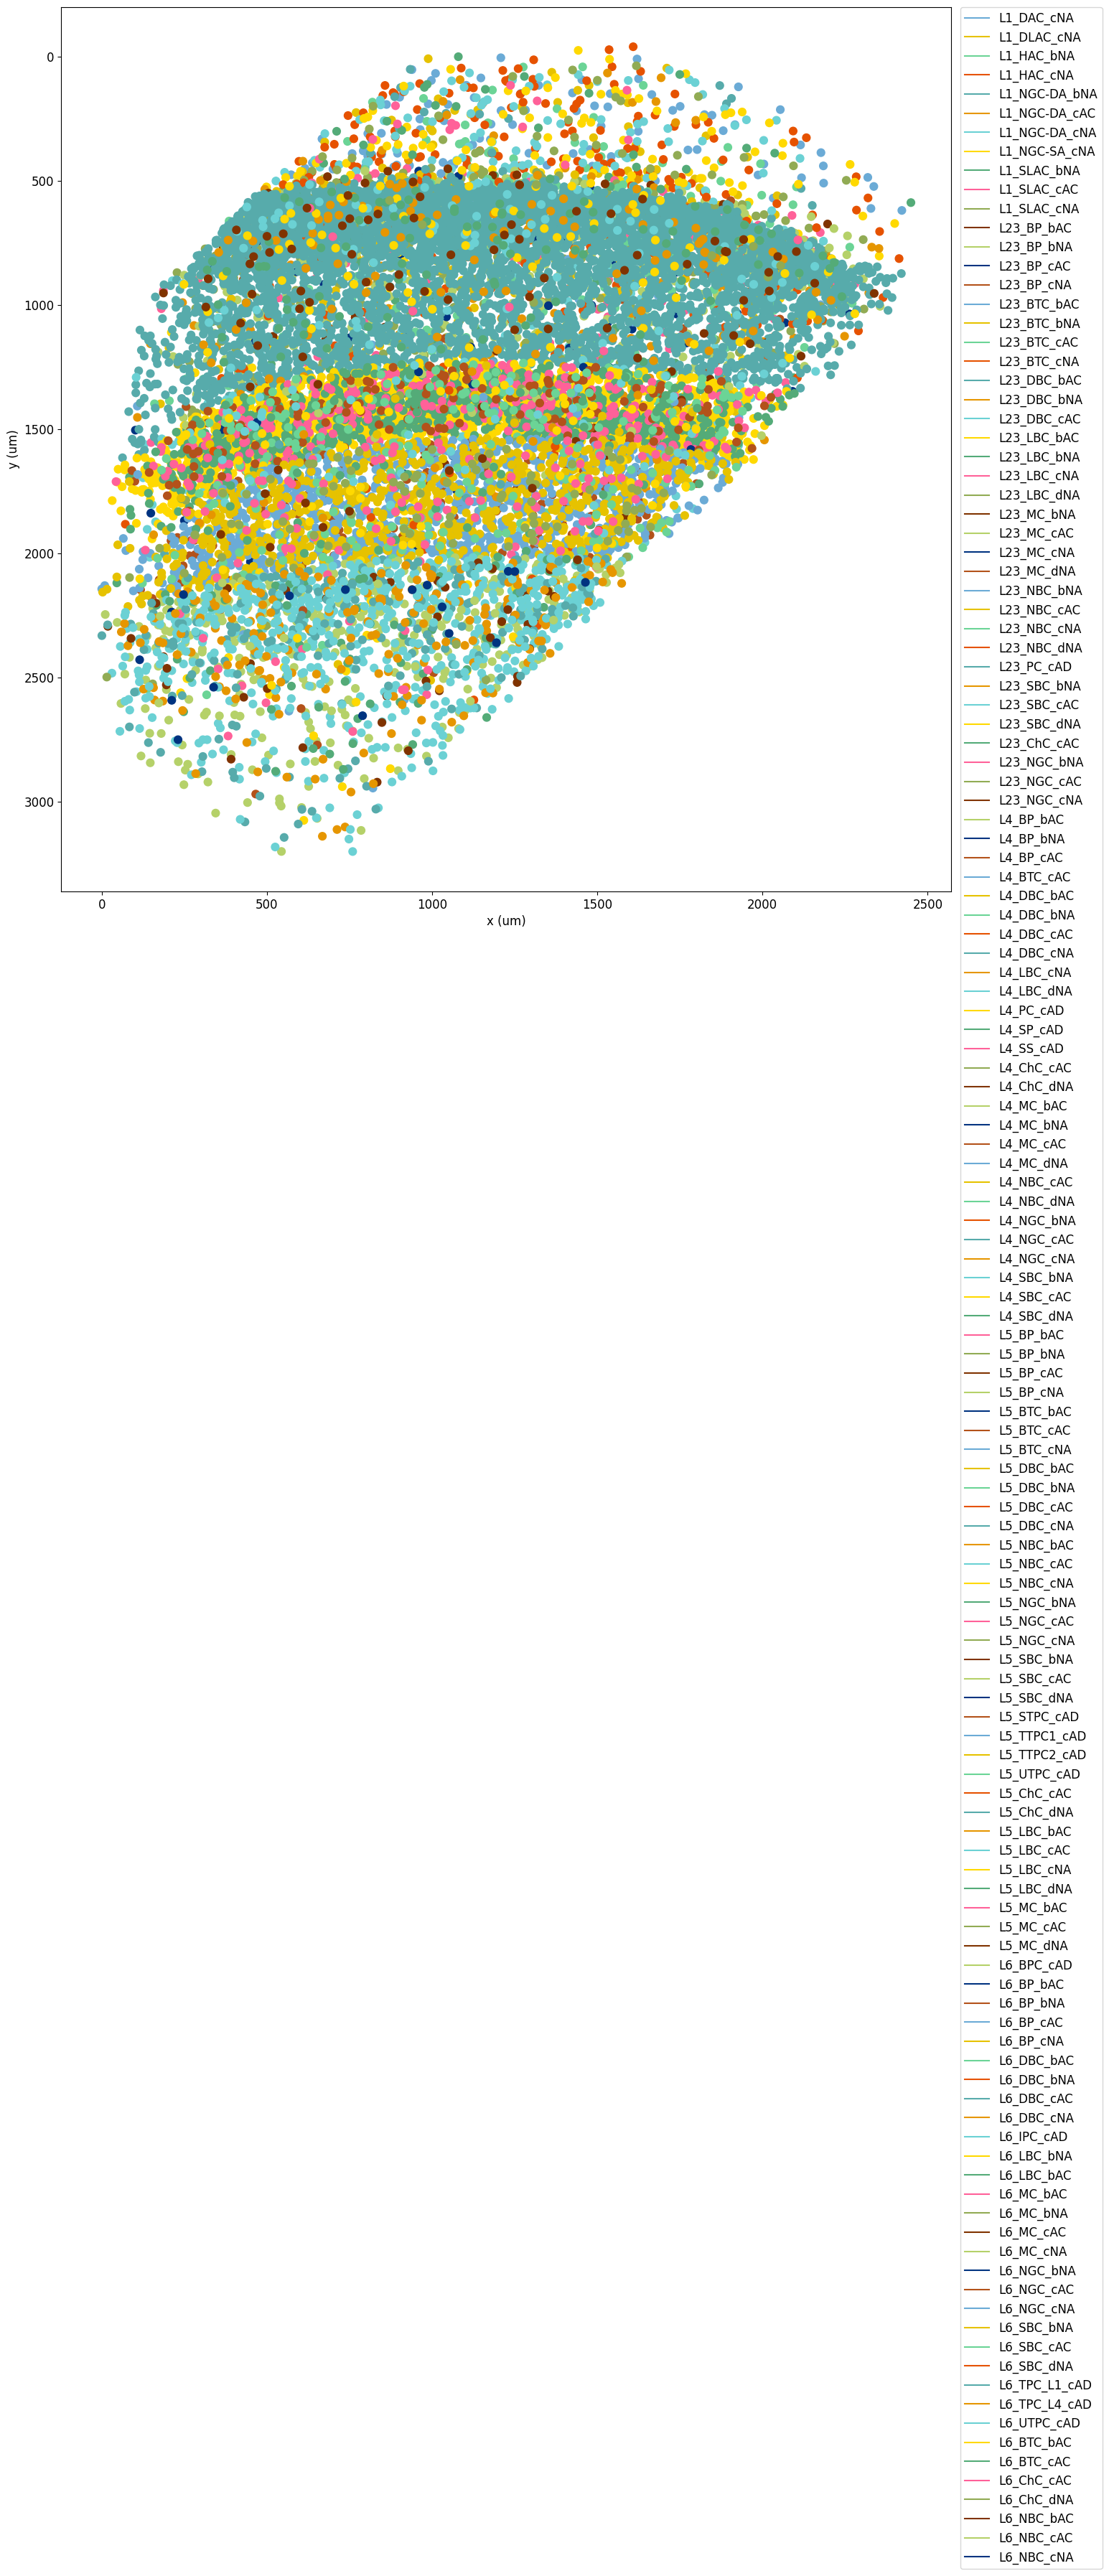

In [59]:
# sim.analysis.plot2Dnet(include=cfg.allpops, view='xy', showConns=True, 
#                                popColors=None, tagsFile=None, figSize=(12, 12), fontSize=8, saveData=None, 
#                                saveFig=False, showFig=True, lineWidth=0.1);
# sim.analysis.plot2Dnet(include=cfg.allpops[0:11] + cfg.Ecells,view='xy', showConns=False, 
#                                popColors=None, tagsFile=None, figSize=(8, 16), fontSize=12, saveData=None, 
#                                saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=cfg.allpops,view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(16, 16), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

Plotting connectivity matrix...


(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[2.82666e+05, 1.58193e+05, 5.21610e+04, 2.12430e+04, 1.05810e+04,
          1.15492e+05, 1.04920e+05, 1.01610e+04, 7.80300e+03, 2.00100e+03,
          5.48400e+03, 5.21400e+03, 7.27200e+03],
         [2.59950e+04, 9.13800e+04, 3.16920e+04, 1.38680e+04, 8.31200e+03,
          7.86400e+04, 6.74450e+04, 8.07200e+03, 7.58700e+03, 2.23200e+03,
          4.39500e+03, 4.40700e+03, 5.71200e+03],
         [5.10600e+03, 2.49750e+04, 9.80400e+03, 4.02900e+03, 2.77200e+03,
          2.81450e+04, 2.40200e+04, 2.94000e+03, 2.18700e+03, 3.15000e+02,
          1.24200e+03, 1.32300e+03, 1.85400e+03],
         [8.78500e+03, 1.03680e+04, 4.94000e+03, 1.51200e+03, 1.00800e+03,
          1.04450e+04, 9.73000e+03, 1.11600e+03, 7.59000e+02, 3.30000e+01,
          4.38000e+02, 3.99000e+02, 6.03000e+02],
         [5.19000e+02, 1.95600e+03, 5.85000e+02, 2.55000e+02, 5.75000e+02,
          4.69000e+03, 3.90500e+03, 5.28000e+02, 7.71000e+02, 3.96000e+02,


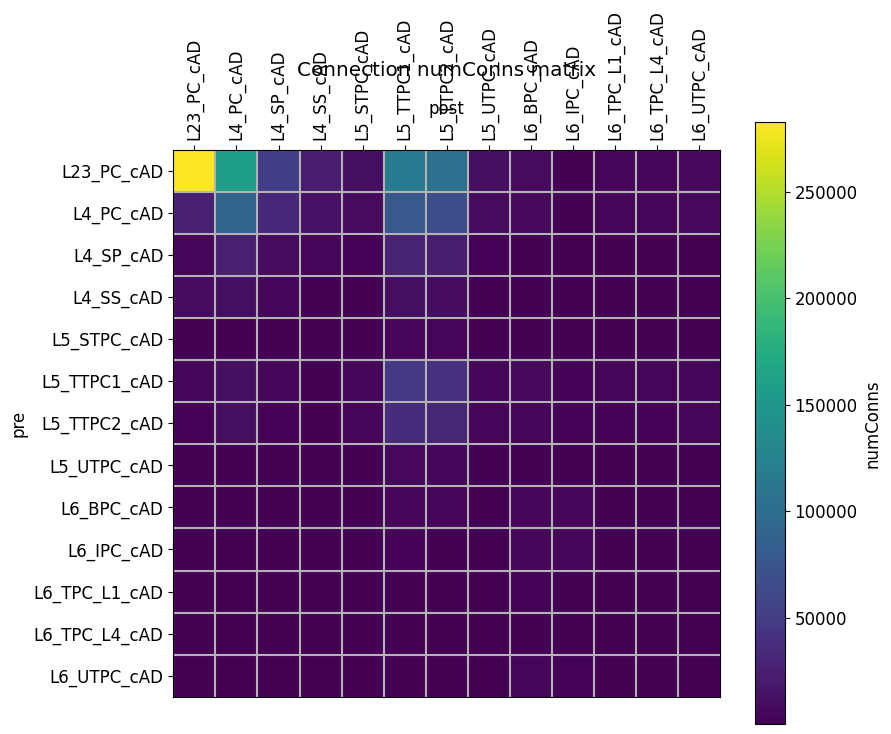

In [51]:
sim.analysis.plotConn(includePre=cfg.Ecells, includePost = cfg.Ecells, feature='numConns', figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=False, showFig=False)

Plotting connectivity matrix...


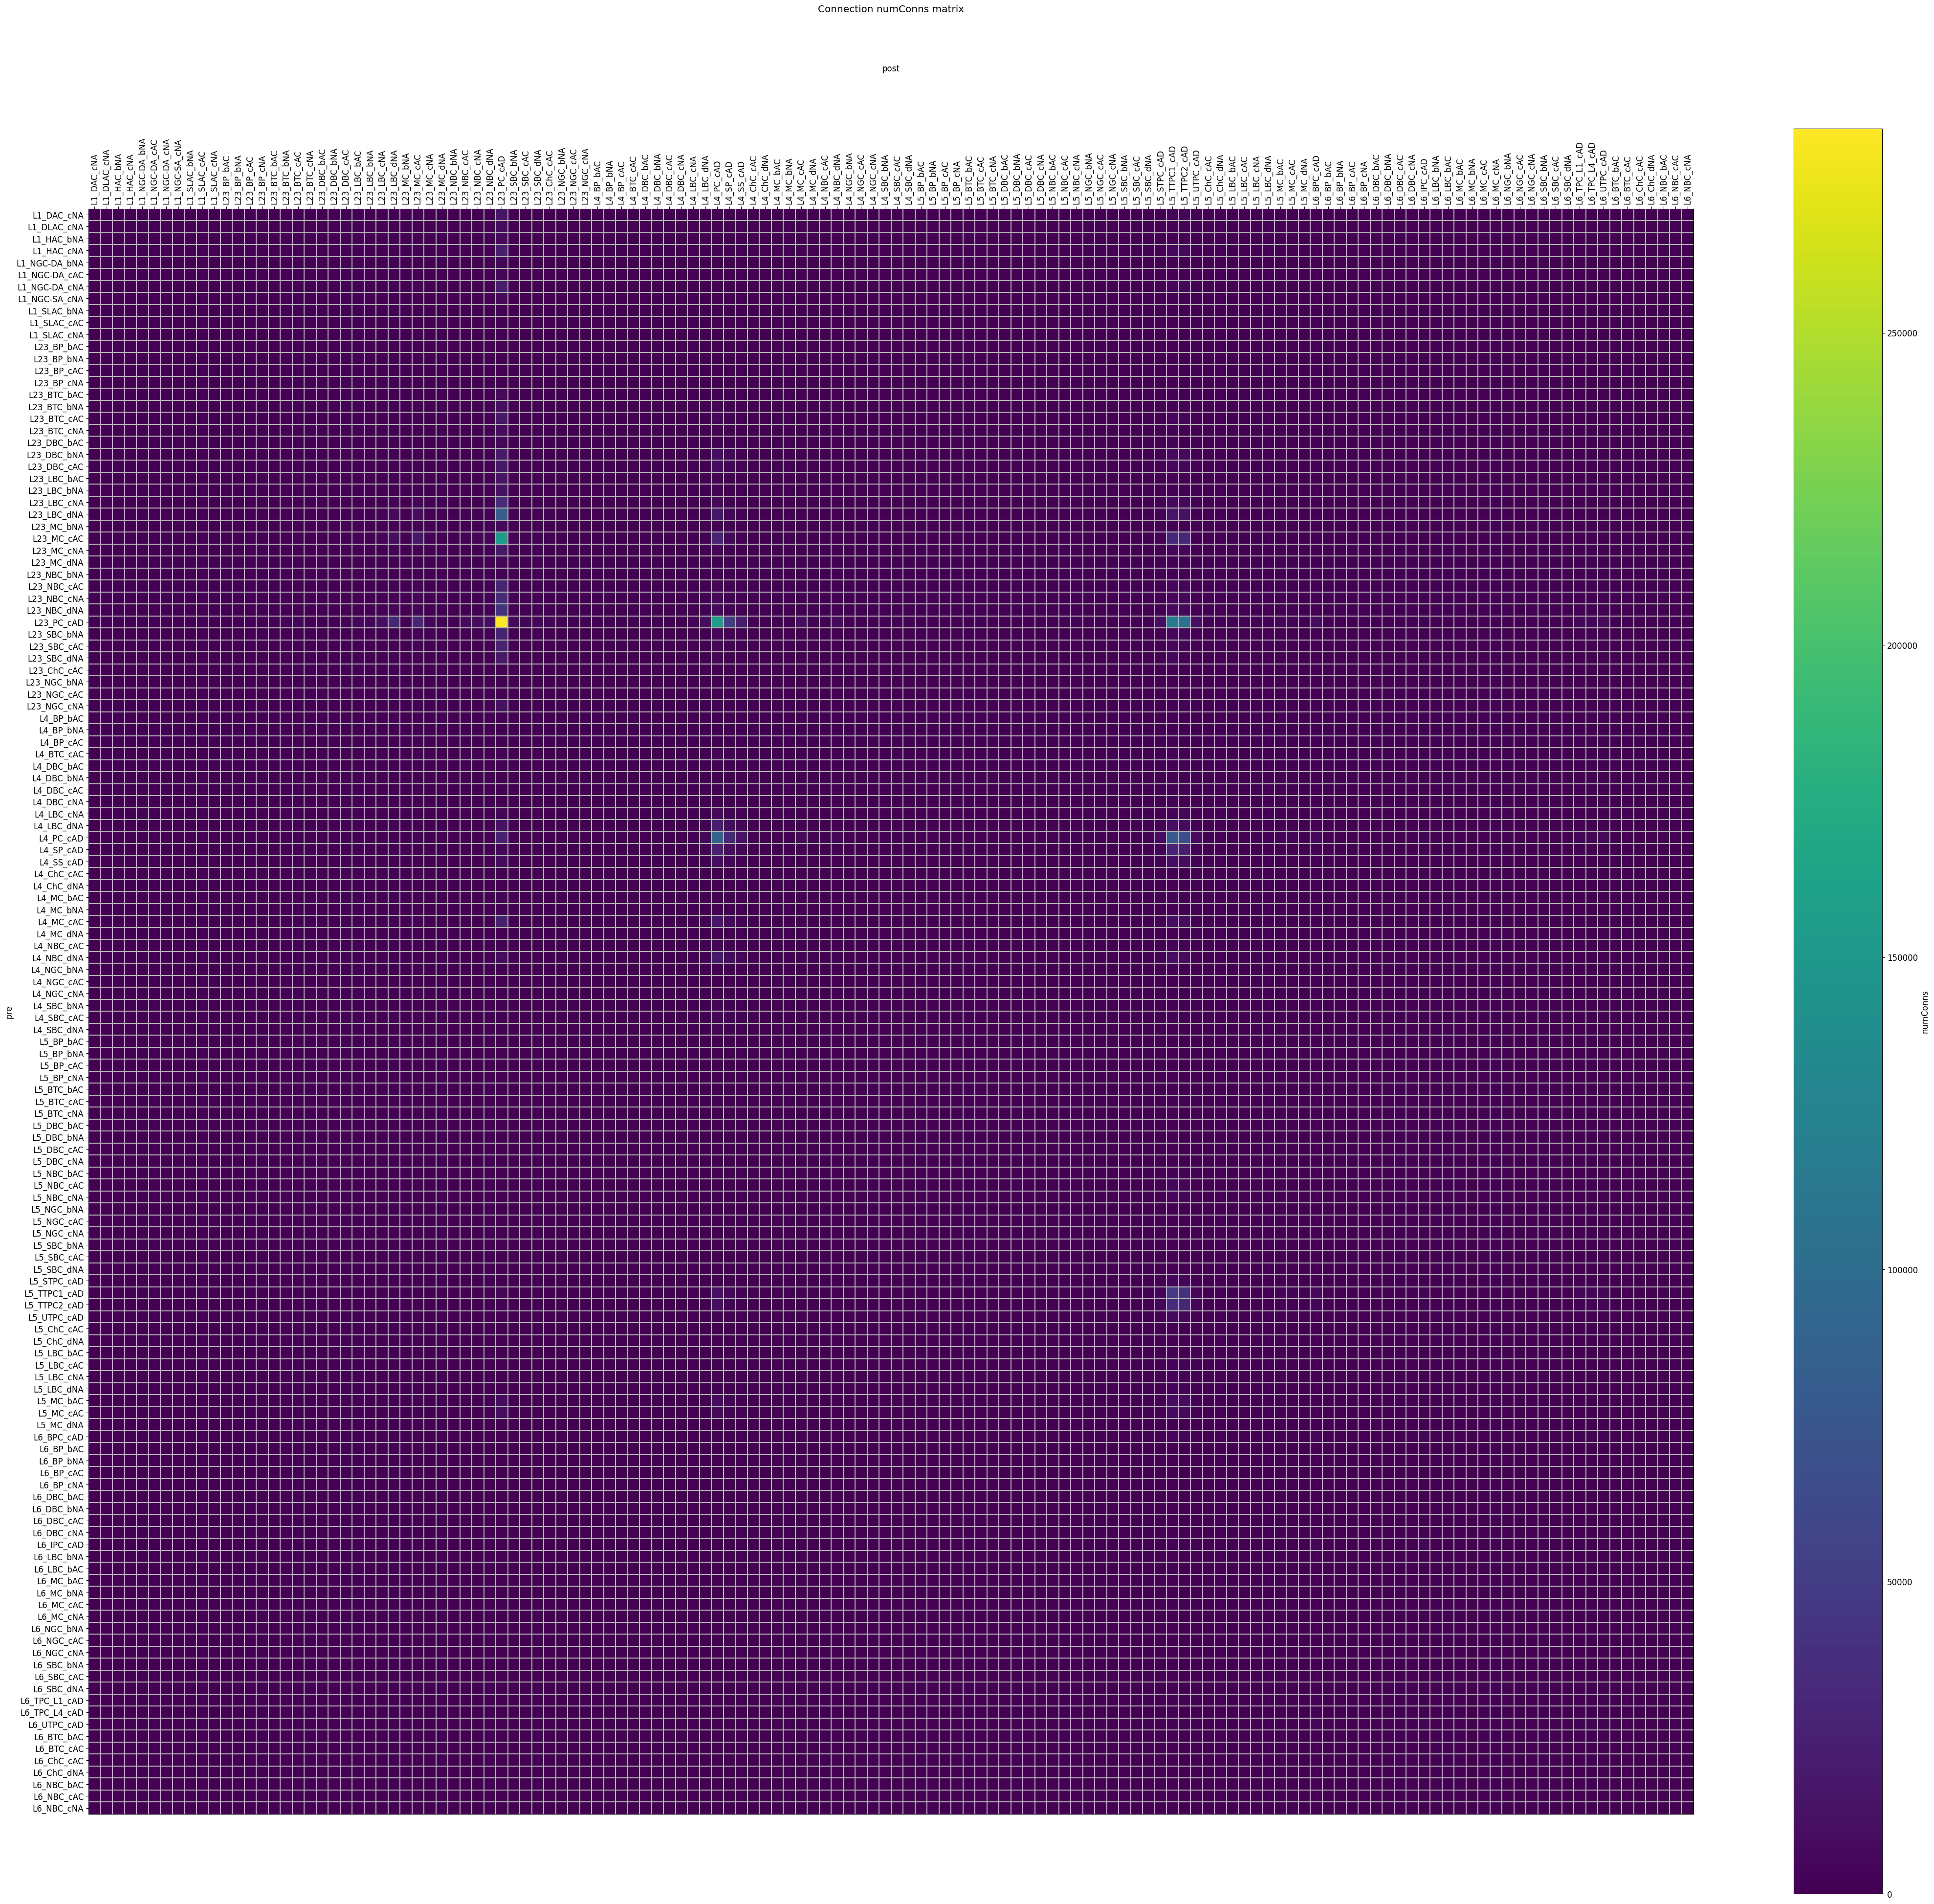

In [52]:
# features = ['numConns','convergence']
test = sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature='numConns', figSize=(48, 48), fontSize=12, saveData=None, 
                               saveFig=False, showFig=False);

In [70]:
filenew = [list(vv) for vv in test[1]['connMatrix']]

In [72]:
filenew.append(test[1]['includePre'])

In [76]:
# File name
file_name = "../data/Net_full/matrix_full.json"

# Save the dictionary to a JSON file
with open(file_name, 'w') as f:
  json.dump(filenew, f, indent=4)

In [53]:
connNumber = connData['connNumber']
synperconnNumber = connData['synperconnNumber']

subPopLabels = cfg.S1pops

connNetPyNE = {}
for pre in subPopLabels:
    connNetPyNE[pre] = {}
    for post in subPopLabels:        
        connNetPyNE[pre][post] = 0
               
for i, cellpre in enumerate(cfg.S1cells):
    for j, cellpost in enumerate(cfg.S1cells):
        pre = cfg.popLabel[cellpre] 
        post = cfg.popLabel[cellpost]     

        connBBP = float(connNumber[pre][post])
        if connBBP > 0:
            synperconn = int(synperconnNumber[pre][post]+0.5)     
            connNetPyNE[pre][post] += test[1]['connMatrix'][i][j]/synperconn
            # print(cellpre,cellpost,i,j,test[1]['connMatrix'][i][j]/synperconn)
  
for pre in subPopLabels:
    for post in subPopLabels:  
            connBBP = float(connNumber[pre][post])      
            if connBBP>0 and  pre in Epops and post in Epops: 
                print('\t%s->%s  \t - \t  BBP = %5.1f   \t    NetPyNE = %5.1f  \t   Error = %5.1f' % (pre,post,connBBP,connNetPyNE[pre][post],100*(connNetPyNE[pre][post]-connBBP)/connBBP),'%')


	L23_PC->L23_PC  	 - 	  BBP = 369455.6   	    NetPyNE = 94222.0  	   Error = -74.5 %
	L23_PC->L4_PC  	 - 	  BBP = 268468.6   	    NetPyNE = 52731.0  	   Error = -80.4 %
	L23_PC->L4_SP  	 - 	  BBP = 88977.3   	    NetPyNE = 17387.0  	   Error = -80.5 %
	L23_PC->L4_SS  	 - 	  BBP = 36323.7   	    NetPyNE = 7081.0  	   Error = -80.5 %
	L23_PC->L5_STPC  	 - 	  BBP = 35253.9   	    NetPyNE = 3527.0  	   Error = -90.0 %
	L23_PC->L5_TTPC1  	 - 	  BBP = 276644.3   	    NetPyNE = 28873.0  	   Error = -89.6 %
	L23_PC->L5_TTPC2  	 - 	  BBP = 251113.9   	    NetPyNE = 26230.0  	   Error = -89.6 %
	L23_PC->L5_UTPC  	 - 	  BBP = 32889.3   	    NetPyNE = 3387.0  	   Error = -89.7 %
	L23_PC->L6_BPC  	 - 	  BBP = 76379.1   	    NetPyNE = 2601.0  	   Error = -96.6 %
	L23_PC->L6_IPC  	 - 	  BBP = 17930.9   	    NetPyNE = 667.0  	   Error = -96.3 %
	L23_PC->L6_TPC_L1  	 - 	  BBP = 52891.7   	    NetPyNE = 1828.0  	   Error = -96.5 %
	L23_PC->L6_TPC_L4  	 - 	  BBP = 49406.0   	    NetPyNE = 1738.0  	   Err

Plotting 2D representation of network cell locations and connections...


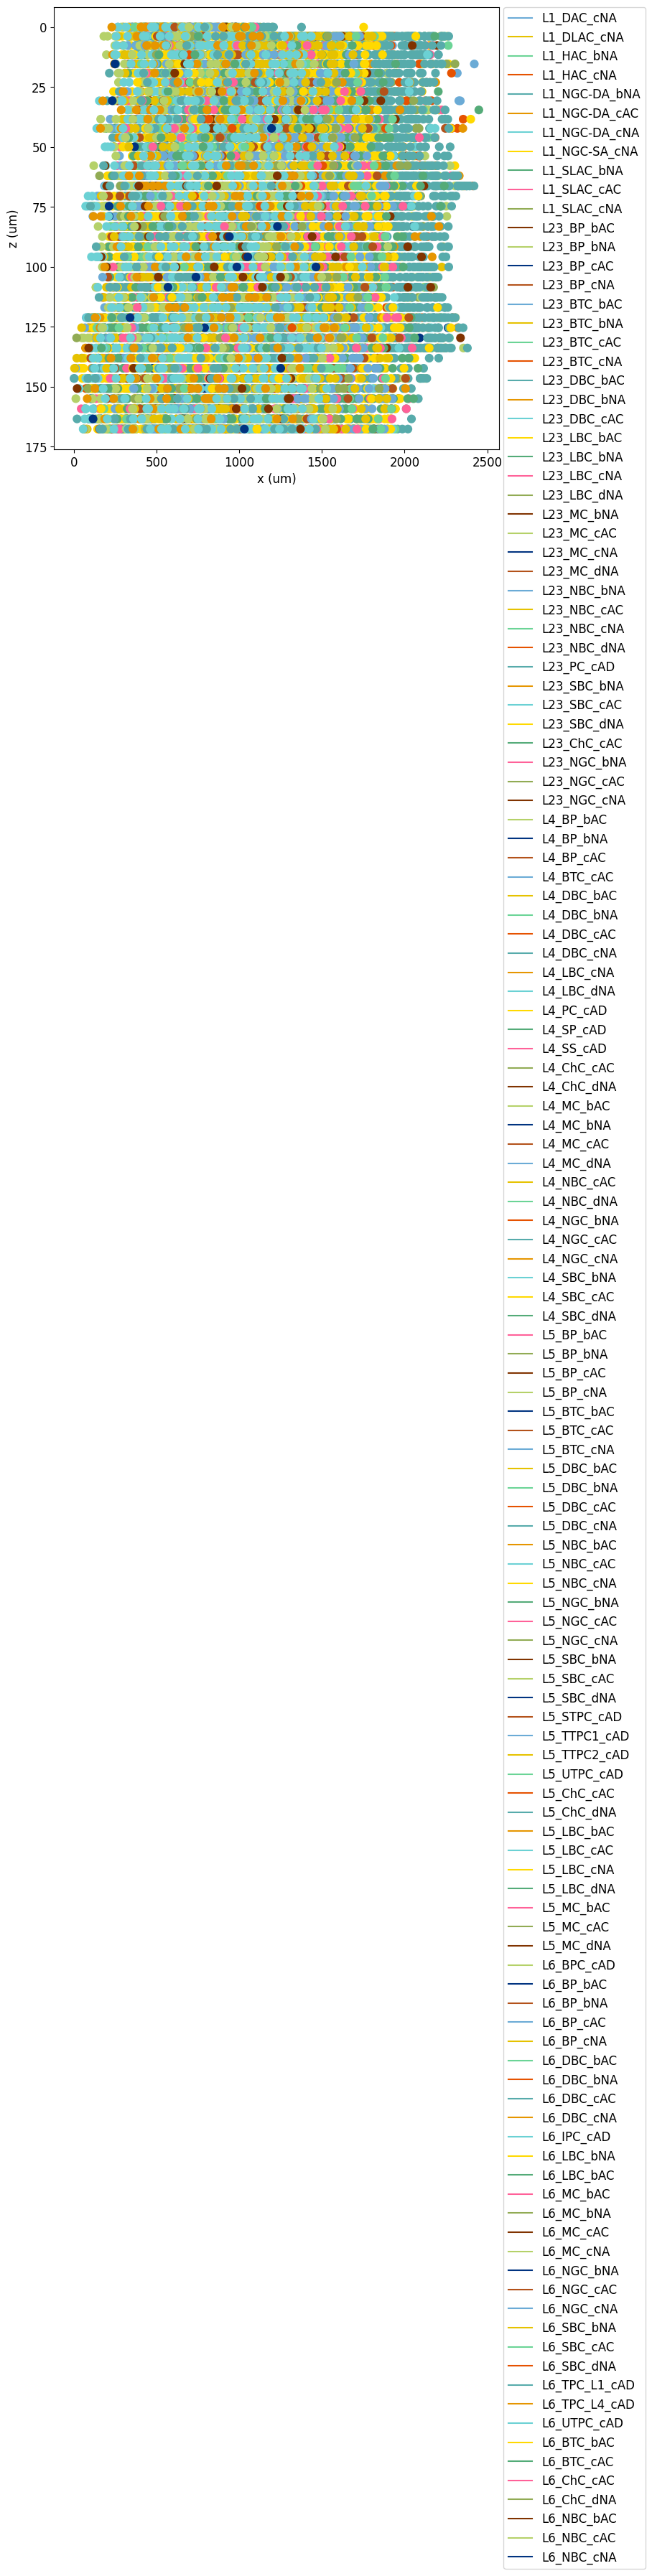

In [54]:
sim.analysis.plot2Dnet(include=cfg.allpops,view='xz', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

In [55]:
sim.net.cells[-1].stims

[]

In [56]:
sim.net.cells[-1].conns

[{preGid: 14644, sec: 'soma_0', loc: 0.045454545454545456, synMech: 'S1_II_STP_Det_0', weight: 0.83, delay: 0.7307335231652466, preLoc: 0.5, hObj: NetCon[2183705]},
 {preGid: 14644, sec: 'soma_0', loc: 0.13636363636363635, synMech: 'S1_II_STP_Det_0', weight: 0.83, delay: 0.7307335231652466, preLoc: 0.5, hObj: NetCon[2183706]},
 {preGid: 14644, sec: 'soma_0', loc: 0.2272727272727273, synMech: 'S1_II_STP_Det_0', weight: 0.83, delay: 0.7307335231652466, preLoc: 0.5, hObj: NetCon[2183707]},
 {preGid: 14644, sec: 'soma_0', loc: 0.3181818181818182, synMech: 'S1_II_STP_Det_0', weight: 0.83, delay: 0.7307335231652466, preLoc: 0.5, hObj: NetCon[2183708]},
 {preGid: 14644, sec: 'soma_0', loc: 0.4090909090909091, synMech: 'S1_II_STP_Det_0', weight: 0.83, delay: 0.7307335231652466, preLoc: 0.5, hObj: NetCon[2183709]},
 {preGid: 14644, sec: 'soma_0', loc: 0.5, synMech: 'S1_II_STP_Det_0', weight: 0.83, delay: 0.7307335231652466, preLoc: 0.5, hObj: NetCon[2183710]},
 {preGid: 14644, sec: 'soma_0', lo